# Chapter 3: Building a Causal Graphical Model

This chapter covers:

- Building a causal DAG to model a Data Generating Process (DGP)
- Using your causal graph as a communication, computation, and reasoning tool
- Building a causal DAG in pgmpy and Pyro
- Training a probabilistic machine learning model using the causal DAG as a scaffold

## The Data Generating Process (DGP)

A **Data Generating Process (DGP)** is the underlying mechanism that produces observed data. In causal inference, we model the DGP to understand not just correlations, but the actual causal relationships between variables.

Below is a simple example: the "broken window" scenario. Jenny and Brian may each throw a rock at a window. The window breaks if the combined impact exceeds the window's strength. This function represents the *true* causal mechanism—it shows how causes (throwing rocks) produce effects (broken window).

In [8]:
def true_dgp(jenny_inclination, brian_inclination, window_strength):
    jenny_throws_rock = jenny_inclination > 0.5
    brian_throws_rock = brian_inclination > 0.5
    if jenny_throws_rock and brian_throws_rock:
        strength_of_impact = 0.8
    elif jenny_throws_rock or brian_throws_rock:
        strength_of_impact = 0.6
    else:
        strength_of_impact = 0.0
    window_breaks = strength_of_impact > window_strength
    return jenny_throws_rock, brian_throws_rock, window_breaks

## Building a Causal DAG in pgmpy

A **Directed Acyclic Graph (DAG)** represents causal relationships as directed edges between nodes. Each edge `(A, B)` means "A causes B" or "A directly influences B."

We'll model a transportation survey with the following variables:
- **A** (Age): young, adult, old
- **S** (Sex): M, F
- **E** (Education): high school, university
- **O** (Occupation): employed, self-employed
- **R** (Residence size): small, big
- **T** (Transportation): car, train, other

The causal structure encodes our domain knowledge:
- Age and Sex influence Education level
- Education influences both Occupation and Residence size
- Occupation and Residence size together influence Transportation choice

```
    A     S
     \   /
       E
      / \
     O   R
      \ /
       T
```

In [9]:
from pgmpy.models import DiscreteBayesianNetwork

model = DiscreteBayesianNetwork(
    [("A", "E"), ("S", "E"), ("E", "O"), ("E", "R"), ("O", "T"), ("R", "T")]
)


## Loading Observational Data

Now we load survey data that was generated according to (or at least consistent with) our causal model. Each row represents one person's responses.

In [10]:
import pandas as pd
url='https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv'
data = pd.read_csv(url)
data

,A,S,E,O,R,T
0,adult,F,high,emp,small,train
1,young,M,high,emp,big,car
2,adult,M,uni,emp,big,other
3,old,F,uni,emp,big,car
4,young,F,uni,emp,big,car
...,...,...,...,...,...,...
495,young,M,high,emp,big,other
496,adult,M,high,emp,big,car
497,young,M,high,emp,small,train
498,young,M,high,emp,small,car


## Learning Conditional Probability Distributions (CPDs)

The `fit()` method learns the **Conditional Probability Distributions (CPDs)** from data. In a Bayesian network, each node has a CPD that specifies:

- For **root nodes** (no parents): P(X) — the marginal distribution
- For **child nodes**: P(X | Parents(X)) — the conditional distribution given parents

These CPDs are also called **Causal Markov Kernels** because they encode the local causal mechanism at each node. Together, they define the full joint distribution:

$$P(A, S, E, O, R, T) = P(A) \cdot P(S) \cdot P(E|A,S) \cdot P(O|E) \cdot P(R|E) \cdot P(T|O,R)$$

This factorization follows from the **Causal Markov Condition**: each variable is independent of its non-descendants given its parents.

In [11]:
model.fit(data)
causal_markov_kernels = model.get_cpds()
print(causal_markov_kernels)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'A': 'C', 'S': 'C', 'E': 'C', 'O': 'C', 'R': 'C', 'T': 'C'}


[<TabularCPD representing P(A:3) at 0x11abc3ef0>, <TabularCPD representing P(E:2 | A:3, S:2) at 0x11abc3fb0>, <TabularCPD representing P(S:2) at 0x11a808ec0>, <TabularCPD representing P(O:2 | E:2) at 0x11c728e90>, <TabularCPD representing P(R:2 | E:2) at 0x11c729250>, <TabularCPD representing P(T:3 | O:2, R:2) at 0x11c728ad0>]


## Examining a Conditional Probability Table

Let's look at the CPD for Transportation (T), which depends on Occupation (O) and Residence size (R).

This table shows P(T | O, R) — the probability of each transportation mode given a person's occupation and residence size. For example:
- Employed people with big residences mostly drive cars (~70%)
- Self-employed people with small residences exclusively drive cars (100%)

Each column sums to 1.0, representing a valid probability distribution for that combination of parent values.

In [ ]:
cmk_T = model.get_cpds("T")
print(cmk_T.to_factor())

We can also examine marginal distributions for root nodes like Sex (S), which has no parents:

In [ ]:
cmk_S = model.get_cpds("S")
print(cmk_S.to_factor())

## Bayesian Parameter Estimation

The default `fit()` uses **Maximum Likelihood Estimation (MLE)**, which simply counts frequencies. This can be problematic with sparse data—if a combination never appears in the data, its probability is estimated as 0.

**Bayesian estimation** with a Dirichlet prior adds "pseudo-counts" to smooth the estimates. This is equivalent to assuming we've seen each combination at least `pseudo_counts` times before observing our data. The result is that:
- Rare combinations get small but non-zero probabilities
- Estimates are more robust with limited data
- As data grows, the prior's influence diminishes

In [ ]:
from pgmpy.estimators import BayesianEstimator
model.fit(
    data,
    estimator=BayesianEstimator,
    prior_type="dirichlet",
    pseudo_counts=1
)
cmk_T = model.get_cpds("T")
print(cmk_T.to_factor())

## Learning with Latent (Unobserved) Variables

Sometimes important causal variables are **latent**—they exist in the causal structure but aren't directly observed in the data. For example, we might hypothesize that Education (E) influences transportation choice, but our survey didn't collect education data.

The **Expectation-Maximization (EM)** algorithm handles this by:
1. **E-step**: Estimate the distribution of latent variables given current parameters and observed data
2. **M-step**: Update parameters to maximize likelihood given the estimated latent values
3. Repeat until convergence

Below, we treat E as latent and learn its CPD from data that only contains A, S, O, R, T. The algorithm infers what the latent variable's states likely represent.

In [ ]:
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import ExpectationMaximization as EM  
url='https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv'
data = pd.read_csv(url)
data_sans_E = data[["A", "S", "O", "R", "T"]]
model_with_latent = DiscreteBayesianNetwork(
    [("A", "E"), ("S", "E"), ("E", "O"), ("E", "R"), ("O", "T"), ("R", "T")], latents=["E"]
)
estimator = EM(model_with_latent, data_sans_E)
cmks_with_latent = estimator.get_parameters(latent_card={"E": 2})

# Find the CPD for latent variable E
cmk_E = next(cpd for cpd in cmks_with_latent if cpd.variable == "E")
print(cmk_E.to_factor())

## Probabilistic Inference: Querying the Model

Once we've learned a Bayesian network, we can perform **inference**—computing probabilities of some variables given evidence about others.

**Variable Elimination** is an exact inference algorithm that:
1. Eliminates variables one by one by summing them out
2. Exploits the factorization structure for efficiency
3. Returns exact posterior probabilities

Below we query: *Given that someone takes the train, what's the probability distribution over their education level?* This is computing P(E | T=train) using Bayes' rule and the learned CPDs.

In [28]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)
query_1 = inference.query(variables=["E"], evidence={"T": "train"})
query_2 = inference.query(variables=["E"], evidence={"T": "car"})
print("train")
print(query_1)
print("car")
print(query_2)  

train
+---------+----------+
| E       |   phi(E) |
+=========+==========+
| E(high) |   0.6162 |
+---------+----------+
| E(uni)  |   0.3838 |
+---------+----------+
car
+---------+----------+
| E       |   phi(E) |
+=========+==========+
| E(high) |   0.5586 |
+---------+----------+
| E(uni)  |   0.4414 |
+---------+----------+


## Building the Same Model in Pyro

**Pyro** is a probabilistic programming language built on PyTorch. Unlike pgmpy's declarative approach (define structure, then fit), Pyro uses a **generative** approach—you write a function that samples from the joint distribution.

Each `pyro.sample()` call:
- Names a random variable (important for inference)
- Specifies its distribution (here, `Categorical` for discrete choices)
- Can condition on parent variables through indexing

The CPD tables are encoded as PyTorch tensors, and the model function implements ancestral sampling through the causal graph.

In [29]:
import torch
import pyro
from pyro.distributions import Categorical

A_alias = ["young", "adult", "old"]
S_alias = ["M", "F"]
E_alias = ["high", "uni"]
O_alias = ["emp", "self"]
R_alias = ["small", "big"]
T_alias = ["car", "train", "other"]

A_prob = torch.tensor([0.3, 0.5, 0.2])
S_prob = torch.tensor([0.6, 0.4])
E_prob = torch.tensor(
    [[[0.75, 0.25], [0.72, 0.28], [0.88, 0.12]], [[0.64, 0.36], [0.7, 0.3], [0.9, 0.1]]]
)
O_prob = torch.tensor([[0.96, 0.04], [0.92, 0.08]])
R_prob = torch.tensor([[0.25, 0.75], [0.2, 0.8]])
T_prob = torch.tensor(
    [[[0.48, 0.42, 0.1], [0.56, 0.36, 0.08]], [[0.58, 0.24, 0.18], [0.7, 0.21, 0.09]]]
)


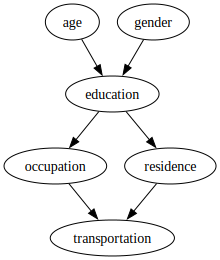

In [31]:
def model():
    A = pyro.sample('age', Categorical(probs=A_prob))
    S = pyro.sample('gender', Categorical(probs=S_prob))
    E = pyro.sample('education', Categorical(probs=E_prob[S][A]))
    O = pyro.sample('occupation', Categorical(probs=O_prob[E]))
    R = pyro.sample('residence', Categorical(probs=R_prob[E]))
    T = pyro.sample('transportation', Categorical(probs=T_prob[R][O]))
    return {'A': A, 'S': S, 'E': E, 'O': O, 'R': R, 'T': T}

pyro.render_model(model)

## Posterior Inference with Importance Sampling

To answer queries like P(E | T=train) in Pyro, we use **importance sampling**:

1. **Condition** the model on observed evidence using `pyro.condition()`
2. Run many forward samples, weighting each by how consistent it is with the evidence
3. The weighted samples approximate the posterior distribution

This is a **Monte Carlo** method—unlike variable elimination, it gives approximate answers but scales to continuous variables and complex models where exact inference is intractable.

`EmpiricalMarginal` extracts samples for a specific variable from the posterior.

In [32]:
import numpy as np
from pyro.distributions import Categorical
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt

conditioned_model = pyro.condition(model, data={"transportation": torch.tensor(1.)}) 

m = 5000

posterior = pyro.infer.Importance(conditioned_model, num_samples=m).run()

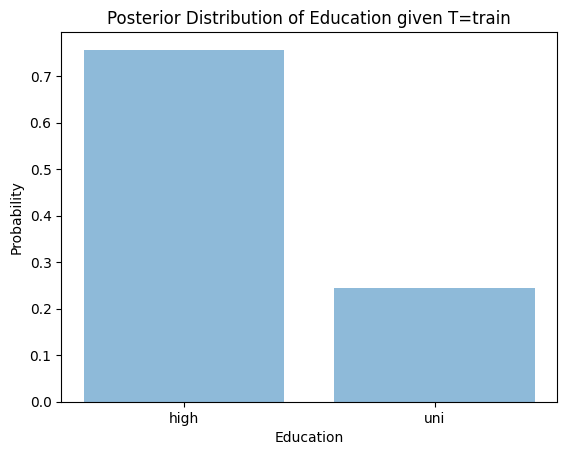

In [33]:
E_marginal = EmpiricalMarginal(posterior, "education")
E_samples = [E_marginal().item() for _ in range(m)]
E_unique, E_counts = np.unique(E_samples, return_counts=True)
E_probs = E_counts / m

plt.bar(E_unique, E_probs, align='center', alpha=0.5)
plt.xticks(E_unique, E_alias)
plt.xlabel("Education")
plt.ylabel("Probability")
plt.title("Posterior Distribution of Education given T=train")
plt.show()

## Generating Synthetic Causal Data with DoWhy

**DoWhy** is a library for causal inference that provides tools for:
- Generating synthetic datasets with known causal structure
- Identifying causal effects from observational data
- Estimating causal effects using various methods
- Refuting estimates with robustness checks

Below we generate a linear dataset with a known causal graph including:
- **Treatments** (v0): The intervention variable
- **Instruments** (Z0, Z1): Variables that affect treatment but not outcome directly
- **Common causes/Confounders** (W0-W4): Variables that affect both treatment and outcome
- **Effect modifiers** (X0, X1): Variables that modify the treatment effect
- **Frontdoor variables** (FD0): Mediators between treatment and outcome

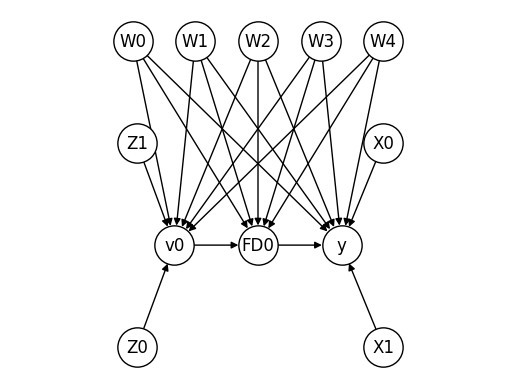

In [39]:
from dowhy import datasets

import networkx as nx
import matplotlib.pyplot as plt

sim_data = datasets.linear_dataset(
    beta=10.0,
    num_treatments=1,
    num_instruments=2,
    num_effect_modifiers=2,
    num_common_causes=5,
    num_frontdoor_variables=1,
    num_samples=100,
    treatment_is_binary=False  # Avoid numpy 2.4 compatibility issue
)

dag = nx.parse_gml(sim_data['gml_graph'])

pos = {
'X0': (600, 350),
'X1': (600, 250),
'FD0': (300, 300),
'W0': (0, 400),
'W1': (150, 400),
'W2': (300, 400),
'W3': (450, 400),
'W4': (600, 400),
'Z0': (10, 250),
'Z1': (10, 350),
'v0': (100, 300),
'y': (500, 300)
}

options = {
"font_size": 12,
"node_size": 800,
"node_color": "white",
"edgecolors": "black",
"linewidths": 1,
"width": 1,
}

nx.draw_networkx(dag, pos, **options)
ax = plt.gca()
ax.margins(x=0.40)
plt.axis("off")
plt.show()

## Summary

This notebook demonstrated the complete workflow for causal graphical modeling:

### 1. Model Specification
- Define the causal DAG structure based on domain knowledge
- Each directed edge represents a direct causal relationship

### 2. Parameter Learning
- **MLE**: Count frequencies from data (default `fit()`)
- **Bayesian estimation**: Add Dirichlet priors for smoothing with sparse data
- **EM algorithm**: Handle latent (unobserved) variables

### 3. Inference
- **Variable Elimination** (pgmpy): Exact inference for discrete models
- **Importance Sampling** (Pyro): Approximate inference that scales to complex models

### 4. Synthetic Data Generation
- **DoWhy**: Generate datasets with known causal structure for testing methods

### Key Takeaways

| pgmpy | Pyro | DoWhy |
|-------|------|-------|
| Declarative: define structure, then fit | Generative: write sampling function | Causal inference pipeline |
| Exact inference with Variable Elimination | Approximate inference with Monte Carlo | Effect estimation & refutation |
| Good for discrete, tabular data | Scales to continuous variables, deep learning | End-to-end causal analysis |

 The causal directed acyclic graph (DAG) can represent our causal assumptions
about the data generating process (DGP).
 The causal DAG is a useful tool for visualizing and communicating your causal
assumptions.
 DAGs are fundamental data structures in computer science, and they admit
many fast algorithms we can bring to bear on causal inference tasks.
 DAGs link causality to conditional independence via the causal Markov property.
 DAGs can provide scaffolding for probabilistic ML models.
 We can use various methods for statistical parameter learning to train a proba-
bilistic model on top of a DAG. These include maximum likelihood estimation
and Bayesian estimation.
 Given a causal DAG, the modeler can choose from a variety of parameteriza-
tions of the causal Markov kernels in the DAG, ranging from conditional proba-
bility tables to regression models to neural networks.
 A causally sufficient set of variables contains all common causes between pairs
in that set.
 You can build a causal DAG by starting with a set of variables of interest,
expanding that to a causally sufficient set, adding variables useful to causal
inference analysis, and finally adding any variables that help the DAG commu-
nicate a complete story.
 Each causal Markov kernel represents a distinct causal mechanism that deter-
mines how the child node is determined by its parents (assuming the DAG is
correct).
 “Independence of mechanism” refers to how mechanisms are distinct from the
others—a change to one mechanism does not affect the others.
 When you build a generative model on the causal DAG, the parameters of each
causal Markov kernel represents an encoding of the underlying causal mecha-
nism. This leads to “parameter modularity,” which enables you to learn each
parameter set separately and even use common sense reasoning to estimate
parameters instead of data.
 The fact that each causal Markov kernel represents a distinct causal mechanism
provides a source of invariance that can be leveraged in advanced tasks, like
transfer learning, data fusion, and invariant prediction.
 You can specify a DAG by the roles variables play in a specific causal inference
task.